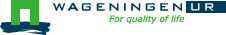



# WOFOST POTATO simulations for India experiment design
This Jupyter notebook will run WOFOST POTATO model to simulate water balance over 90 days period.  
The objectives are:  
1. Provide reference information about the effectiveness of the treatment.  
2. Verifying weather or not the treatment will cause earlier crop failure.  
3. Identify potential parameters to calibrate, also to suggest key plant traits to measure in the field. 

# 1. Importing the relevant modules

First the required modules need to be imported. For this *getting started* we only need PCSE, pandas and matplotlib

In [ ]:
%matplotlib inline
import sys, os
import pandas as pd
import pcse
import pandas
import matplotlib
from plotnine import *
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

# Read parameter values

In [ ]:
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader
cropd = YAMLCropDataProvider(fpath='../../WOFOST_crop_parameters/')
soild = CABOFileReader('../inputs/ec3 sandyloam.soil')
from pcse.util import WOFOST72SiteDataProvider
sited = WOFOST72SiteDataProvider(WAV=0, CO2=360)
print(sited)
# help(WOFOST72SiteDataProvider)


In [ ]:
from pcse.base import ParameterProvider
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

In [ ]:
from pcse.fileinput import ExcelWeatherDataProvider
wdp = ExcelWeatherDataProvider('../inputs/india2021-22.xlsx')
print(wdp)

In [ ]:
# Verify the weather data 
weather = pd.read_excel('../inputs/india2021-22.xlsx', skiprows=10)
weather.drop(axis=0, index = 0, inplace=True)
weather[['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOWDEPTH']] = weather[['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOWDEPTH']].apply(pd.to_numeric)
weather.DAY = pd.to_datetime(weather.DAY)
# verify if forced 0 success
weather.set_index('DAY', inplace=True)
weather.plot(y = 'RAIN')

In [ ]:
cols = ['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOWDEPTH']
#https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
plt.subplots_adjust(hspace=0.5)
for col, ax in zip(cols, axes.ravel()):    
    weather[[col]].plot(ax=ax)
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()

In [ ]:
weather[['TMAX', 'TMIN']].plot()

### Temperature is a bit high

### Run a potential potato model with india weather and dutch cultivar

In [ ]:
# NO IRRIGATION AGRONOMANAGEMNT 
import yaml
yaml_agro = """
- 2021-10-05:
    CropCalendar:
        crop_name: potato
        variety_name: Potato_704
        crop_start_date: 2021-10-10
        crop_start_type: sowing
        crop_end_date: 2022-01-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null       
    StateEvents: null
"""
agromanagement_null = yaml.safe_load(yaml_agro)

In [ ]:
from pcse.models import Wofost72_WLP_FD, Wofost72_PP
wofsim = Wofost72_PP(parameters, wdp, agromanagement_null)

In [ ]:
wofsim.run_till_terminate()
PP_results = pd.DataFrame(wofsim.get_output())
PP_results.day = pd.to_datetime(PP_results.day)
PP_results.set_index("day", inplace=True)
PP_results.columns

Table 2. Description of the output of Potential Crop Production table window.
YEAR - year of the simulation time step  
DAY - day of year of the simulation time step (1-366)  
IDSEM  - number of days since emergence (d)   
DVS - development stage of crop (-)  
TSUM - thermal time since emergence (C d)  
WLV - dry weight of living leaves (kg ha-1)  
WST - dry weight of living stems (kg ha-1)  
WSO - dry weight of living storage organs (kg ha)  
**TAGP - total above ground production (dead and living plant organs) (kg ha-1)**  
TWRT - total dry weight of roots (dead and living) (kg ha-1)  
TWLV - total dry weight of leaves (dead and living) (kg ha-1)  
TWST - total dry weight of stems (dead and living) (kg ha-1)  
TWSO - total dry weight of storage organs (dead and living) (kg ha-1)  
LAI - leaf area index (leaf area)/(soil area) (ha ha-1)  
TRA - transpiration rate (mm d-1)  
GASS - gross assimilation rate (kg (CH2O) ha-1 d-1)   
MRES - maintenance respiration rate (kg (CH2O) ha-1 d-1)  
DMI - rate of dry matter increase (kg ha-1 d-1).

**The current cultivar 704 doesn't work in india weather**  
LAI is too low   
TAGP is only a third  
TRA is low 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,10))
for n, col in enumerate(['LAI', 'TAGP', 'TRA', 'TWSO', 'TWLV', 'TWST', 'TWRT', 'RD', 'SM']):
    ax = plt.subplot(3, 3, n + 1)
    PP_results[[col]].plot(ax=ax)
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")


## Try the other four cultivars available in the potato paremeters 

In [ ]:
# NO IRRIGATION AGRONOMANAGEMNT 
import yaml
yaml_agro = """
- 2021-10-05:
    CropCalendar:
        crop_name: potato
        variety_name: {cultivar}
        crop_start_date: 2021-10-10
        crop_start_type: sowing
        crop_end_date: 2022-01-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null       
    StateEvents: null
"""

results = []
cultivars = ["Potato_70" + str(i) for i in list(range(1, 5))]
for i in cultivars:
    print(i)
    # update agromanagement with new start date and load it with yaml.load
    tmp = yaml_agro.format(cultivar=i)
    agromanagement = yaml.safe_load(tmp)
    # run wofost and collect output
    wofost = Wofost72_PP(parameters, wdp, agromanagement)
    wofost.run_till_terminate()
    output = wofost.get_output()
    df = pd.DataFrame(output).set_index("day")
    results.append(df)

In [ ]:
results[1]

In [ ]:
colors = ['k','r','g','b']
fig5, axes5 = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for c, df, cultivar in zip(colors, results, cultivars):
    for key, axis in zip(df.columns, axes5.flatten()):
        df[key].plot(ax=axis, title=key, color=c, label = cultivar)
        # plt.legend(loc="upper left")        
axes5[0][0].legend()
fig.legend( loc='upper center')
fig5.autofmt_xdate()

In [ ]:
#compile my agro
Amount = pd.read_excel("c:/Users/cflfcl/Dropbox/2. PhD/MeetingNotes/Irrigation schedule CY22.xlsx", \
                        usecols='K:V')
# add dates 
Amount['Date'] = pd.date_range(start='10/05/2021', periods=90)
Amount['Date'] = Amount.Date.dt.strftime("%Y-%m-%d")


In [ ]:
control = Amount.loc[Amount['Control'] != 0, ['Date','Control']]

In [ ]:
dates = []
for i in control.iterrows():
    application = "\n        - " + i[1][0] + ": {amount: " + str(i[1][1]/10) + "," + " efficiency: 0.7}"
    dates.append(application)

dates = ''.join(dates)


In [ ]:
import yaml
yaml_agro = """
- 2021-10-05:
    CropCalendar:
        crop_name: potato
        variety_name: potato01
        crop_start_date: 2021-10-10
        crop_start_type: planting
        crop_end_date: 2022-01-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:        """ + \
        dates +\
        """
    StateEvents: null
"""
agromanagement = yaml.safe_load(yaml_agro)


In [ ]:
# wofost = Wofost72_WLP_FD(parameters, wdp, agromanagement)
# wofost.run_till_terminate()

In [ ]:
# df_results = pd.DataFrame(wofost.get_output()).set_index("day")
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
# df_results['LAI'].plot(ax=axes[0], title="Leaf Area Index")
# df_results['SM'].plot(ax=axes[1], title="Root zone soil moisture")
# fig.autofmt_xdate()

Showing the differences in irrigation events
============================================

We combine the `SM`  column from the different data frames in a new dataframe and plot the results to see the effect of the differences in agromanagement.

## The main loop for making several WOFOST runs

In [ ]:
Amount.columns
treatments = ['Control', 'Control_75%', 'Control_50%', 'Early drought_75%',
              'Late drought_75%', 'Early drought 50%', 'Late drought 50%',
              'Middle drought_75%', 'Middle drought_50%', 'Early_Middle_75%',
              'Early_Middle_50%']
results = []
for col in treatments:
    df = Amount.loc[Amount[col] != 0, ['Date', col]]
    # print(df) # just checking 
    print("Processing " + col)
    dates = []
    for i in df.iterrows():
        application = "\n            - " + i[1][0] + ": {amount: " + str(i[1][1]/10) + "," + " efficiency: 0.7}"
        dates.append(application)
    dates = ''.join(dates)
    # print(dates) # checking 
    print("Assembing the irrigation events for " + col)
    yaml_agro = """
    - 2021-10-05:
        CropCalendar:
            crop_name: potato
            variety_name: potato01
            crop_start_date: 2021-10-10
            crop_start_type: emergence
            crop_end_date: 2022-01-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:
        -   event_signal: irrigate
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:             """ + dates +\
        """
        StateEvents: null
        """
    agromanagement = yaml.safe_load(yaml_agro)
    # agrolist.append(agromanagement)
    print("Simulating " + col)
    wofost = Wofost72_PP(parameters, wdp, agromanagement)
    wofost.run_till_terminate()
    sim_res = pd.DataFrame(wofost.get_output())
    sim_res.day = pd.to_datetime(sim_res.day)
    sim_res['Treatment'] = col

    results.append(sim_res)


In [ ]:
df_results = pd.concat(results)
df_lai_sm = df_results.loc[:,['day','Treatment','LAI', 'SM']]
# .melt(id_vars=['day', 'Treatment'])
df_results

In [ ]:
from mizani.breaks import date_breaks
from mizani.formatters import date_format
df_lai_sm_long = df_lai_sm.melt(id_vars=['day', 'Treatment'])
# ggplot(df_lai_sm, aes(x = 'day', y = 'SM', color = 'Treatment')) +\
#     geom_line() + \
#     facet_wrap('Treatment', scales= 'free_y',ncol = 2) + \
#     scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%m-%d')) + \
#     theme(figure_size=(16, 10))
ggplot(df_lai_sm_long, aes(x = 'day', y = 'value', color = 'Treatment')) +\
    geom_line() + \
    facet_grid('variable ~ Treatment', scales= 'free_y') + \
    scale_x_datetime(breaks=date_breaks('4 weeks'), labels=date_format('%b')) + \
    theme(figure_size=(16, 8))

In [ ]:
df_lai_sm

# The timing treatment 


In [ ]:
#compile my agro
Timing = pd.read_excel("c:/Users/cflfcl/Dropbox/2. PhD/MeetingNotes/Irrigation schedule CY22.xlsx", sheet_name="TIMING",
                        usecols='A:H')
# add dates 
Timing['Date'] = pd.date_range(start='10/05/2021', periods=90)
Timing['Date'] = Timing.Date.dt.strftime("%Y-%m-%d")


In [ ]:
Timing.columns

In [ ]:
treatments = ['Control', 'Control_75%', 'Control_50%', 'Full_Every_2nd_week',
              'Full_Every_3rd_week', '75%_Every_2nd_week', '75%_Every_3rd_week']
results = []
for col in treatments:
    df = Timing.loc[Timing[col] != 0, ['Date', col]]
    # print(df) # just checking 
    print("Processing " + col)
    dates = []
    for i in df.iterrows():
        application = "\n            - " + i[1][0] + ": {amount: " + str(i[1][1]) + "," + " efficiency: 0.7}"
        dates.append(application)
    dates = ''.join(dates)
    # print(dates) # checking 
    print("Assembing the irrigation events for " + col)
    yaml_agro = """
    - 2021-10-05:
        CropCalendar:
            crop_name: potato
            variety_name: potato01
            crop_start_date: 2021-10-10
            crop_start_type: emergence
            crop_end_date: 2022-01-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:
        -   event_signal: irrigate
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:             """ + dates +\
        """
        StateEvents: null
        """
    agromanagement = yaml.safe_load(yaml_agro)
    # agrolist.append(agromanagement)
    print("Simulating " + col)
    wofost = Wofost72_WLP_FD(parameters, wdp, agromanagement)
    wofost.run_till_terminate()
    sim_res = pd.DataFrame(wofost.get_output())
    sim_res.day = pd.to_datetime(sim_res.day)
    sim_res['Treatment'] = col

    results.append(sim_res)


In [ ]:
df_results = pd.concat(results)
df_lai_sm = df_results.loc[:,['day','Treatment','LAI','SM']]
df_lai_sm_long = df_lai_sm.melt(id_vars=['day', 'Treatment'])
ggplot(df_lai_sm, aes(x = 'day', y = 'SM', color = 'Treatment')) +\
    geom_line() + \
    facet_wrap('Treatment', scales= 'free_y',ncol = 2) + \
    scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%m-%d')) + \
    theme(figure_size=(16, 10))

ggplot(df_lai_sm_long, aes(x = 'day', y = 'value', color = 'Treatment')) +\
    geom_line() + \
    facet_grid('variable ~ Treatment', scales= 'free_y') + \
    scale_x_datetime(breaks=date_breaks('4 weeks'), labels=date_format('%b')) + \
    theme(figure_size=(16, 10))

In [ ]:
from pcse.models import LINTUL3
LINTUL3sim = LINTUL3(parameters, wdp, agromanagement)